# Project

## Part 1

In [1]:
#packages
import pandas as pd
from plotnine import *
from matplotlib.dates import DateFormatter
data = pd.read_csv("/Users/stolieerickson/Documents/MSBA/Fall/GSB544-Computing/Project/data_clean.csv")
#date variable
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

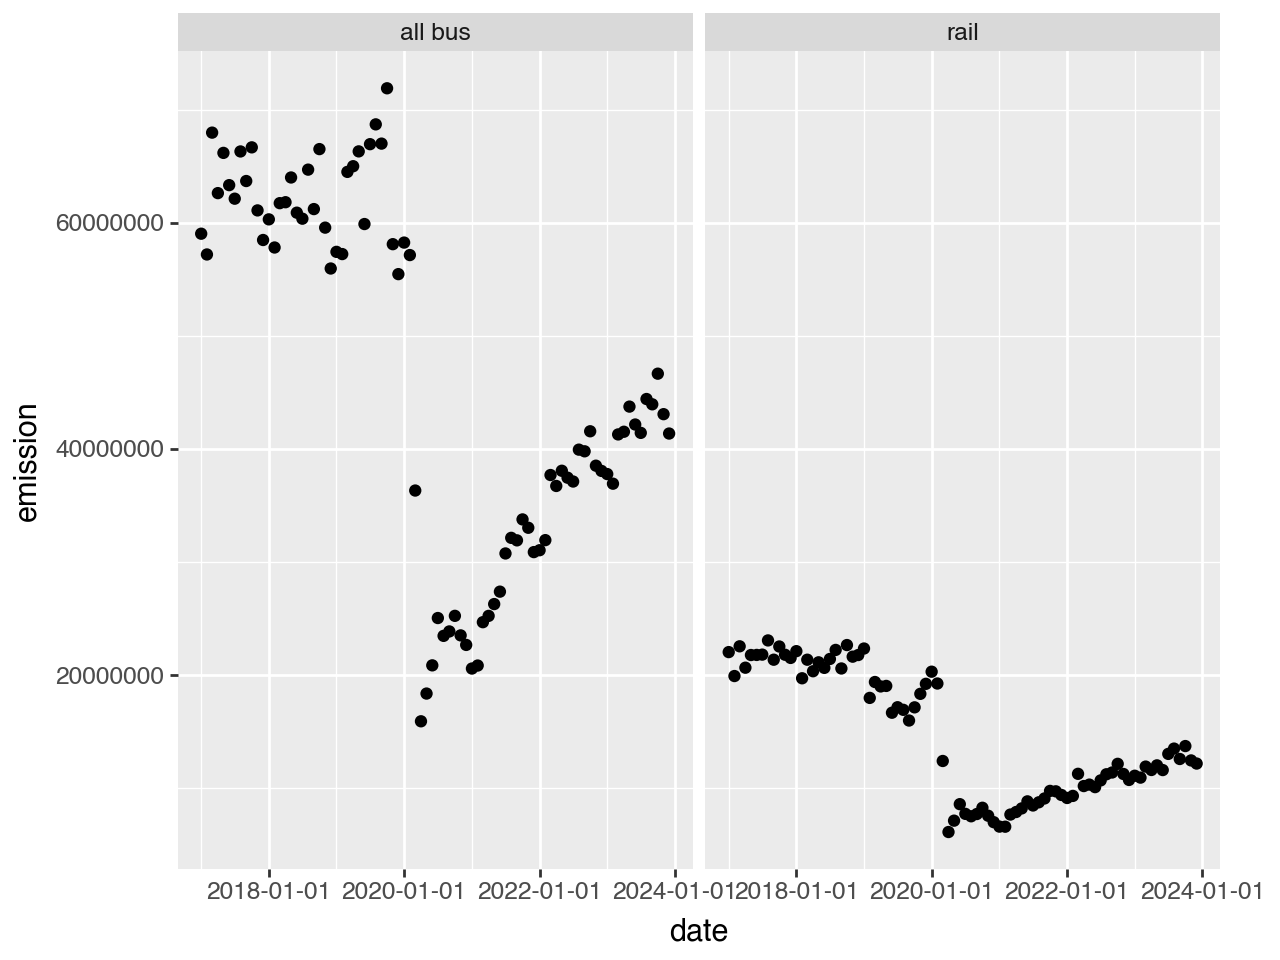

In [2]:

(ggplot(data, aes(x = "date", y = "emission")) +
    geom_point() +
    facet_wrap("transportation_type")
)

<positron-console-cell-3>:13: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


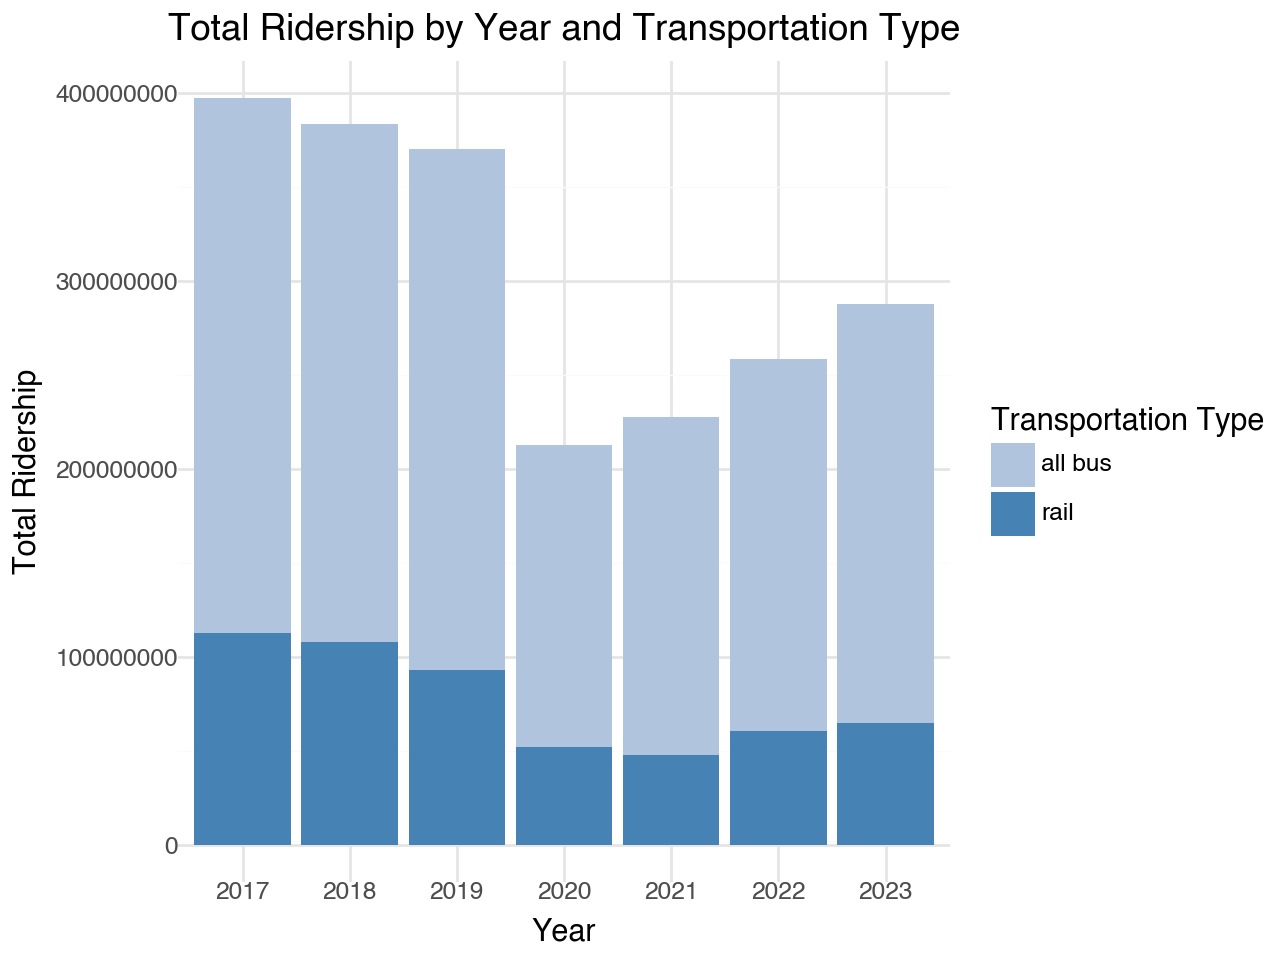

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


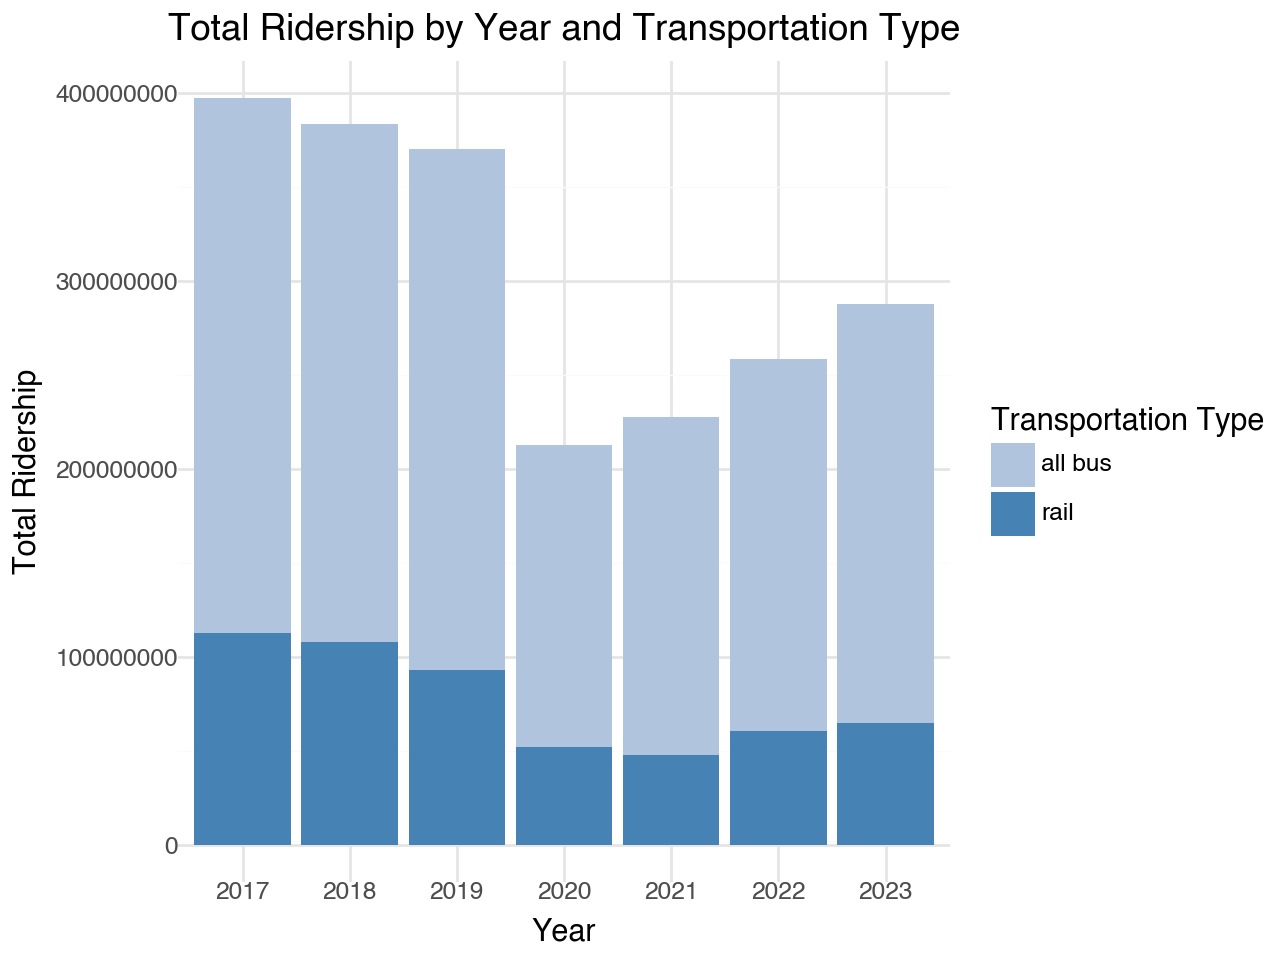

In [3]:
plot = (
    ggplot(data, aes(x='factor(year)', y='total_ridership', fill='transportation_type')) +
    geom_bar(stat='identity') +
    labs(title='Total Ridership by Year and Transportation Type',
         x='Year',
         y='Total Ridership',
         fill='Transportation Type') +
    scale_fill_manual(values=['lightsteelblue', 'steelblue']) + 
    theme_minimal()
)

# Display the plot
print(plot)

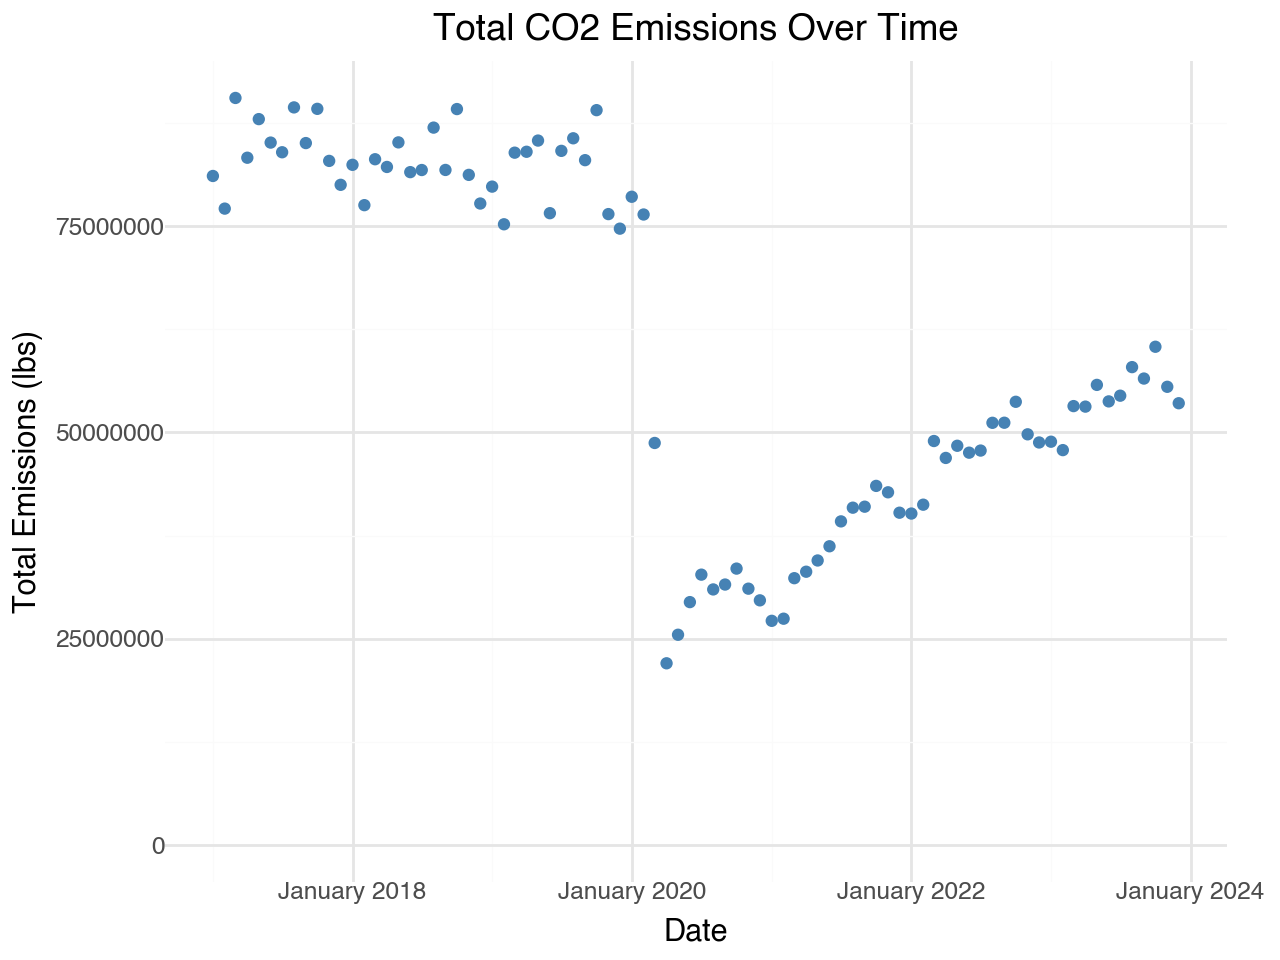

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


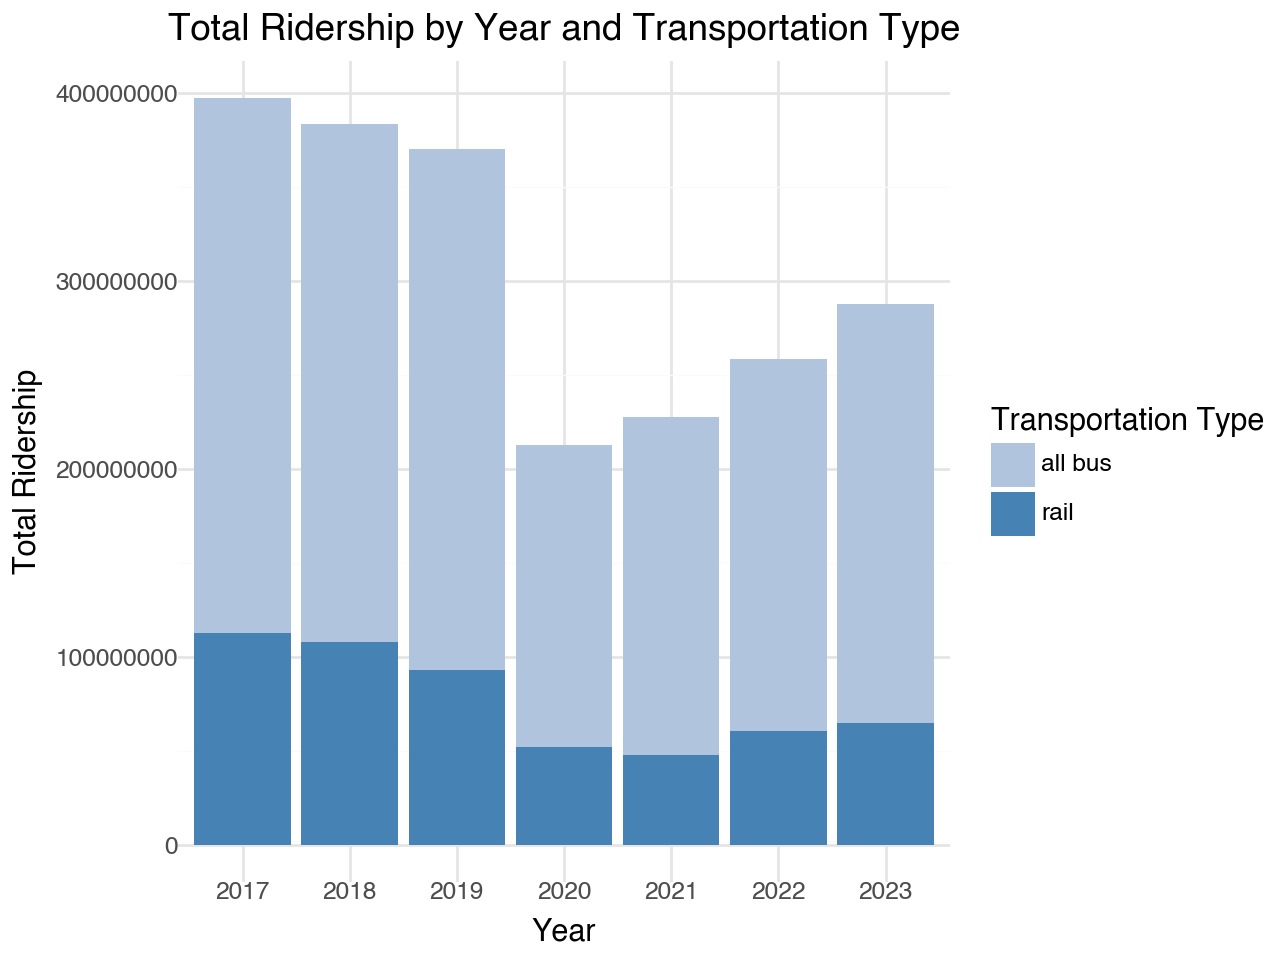

In [4]:

# Aggregate to get total emissions per month
monthly_emissions = data.groupby('date', as_index=False).agg(total_emission=('emission', 'sum'))

# Create the scatter plot with formatted date labels
(
    ggplot(monthly_emissions, aes(x='date', y='total_emission')) +
    geom_point(color="steelblue") +
    labs(title='Total CO2 Emissions Over Time',
         x='Date',
         y='Total Emissions (lbs)') +
    scale_x_date(date_labels='%B %Y') +  # Format dates as "March 2018"
    ylim(0, None) +
    theme_minimal()
)



## Part 2

### Bubble Plot

x: total ridership

y: emissions

color: bus/rail

size: average gas price

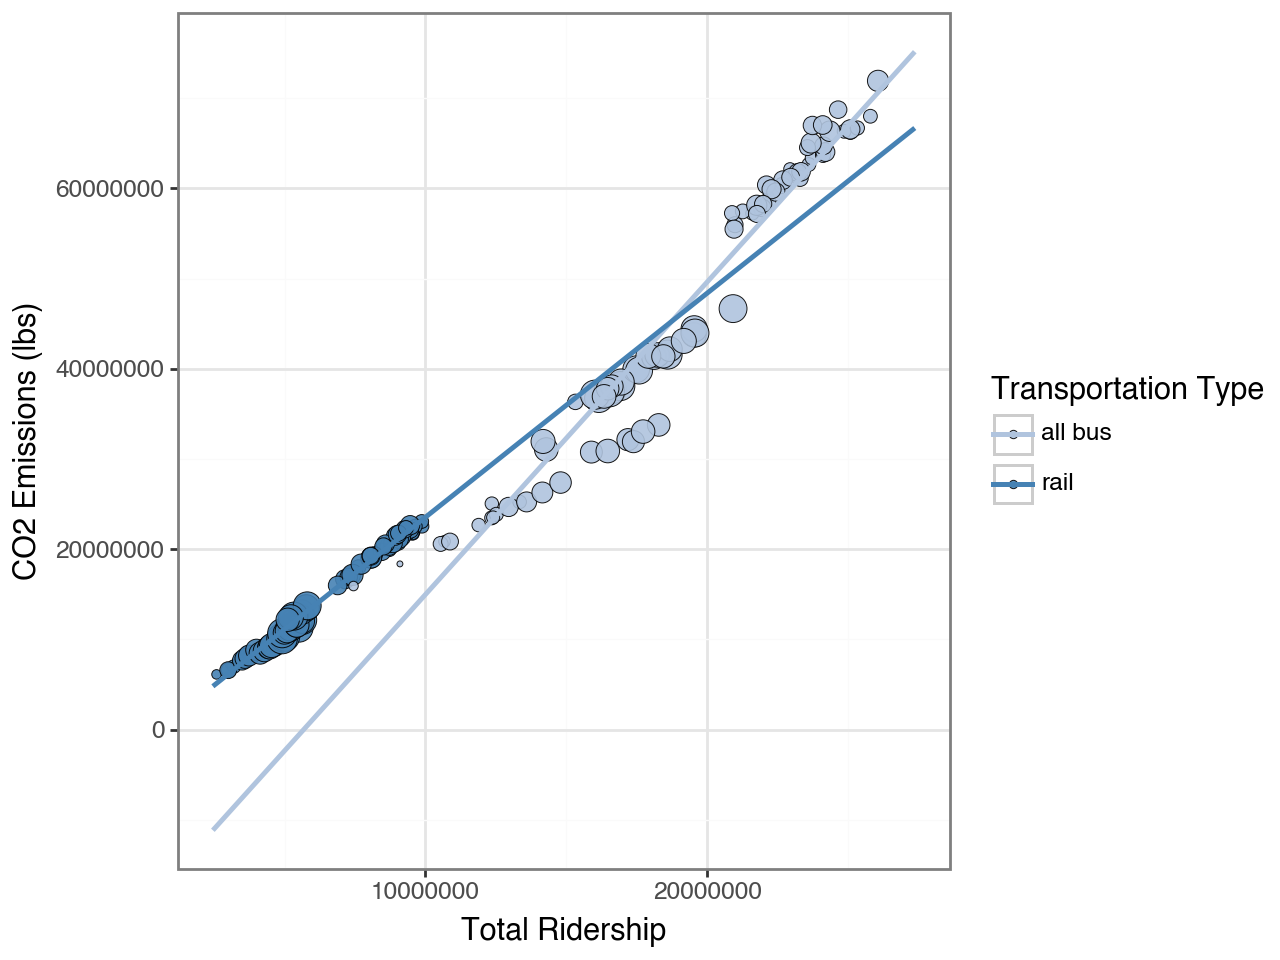

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


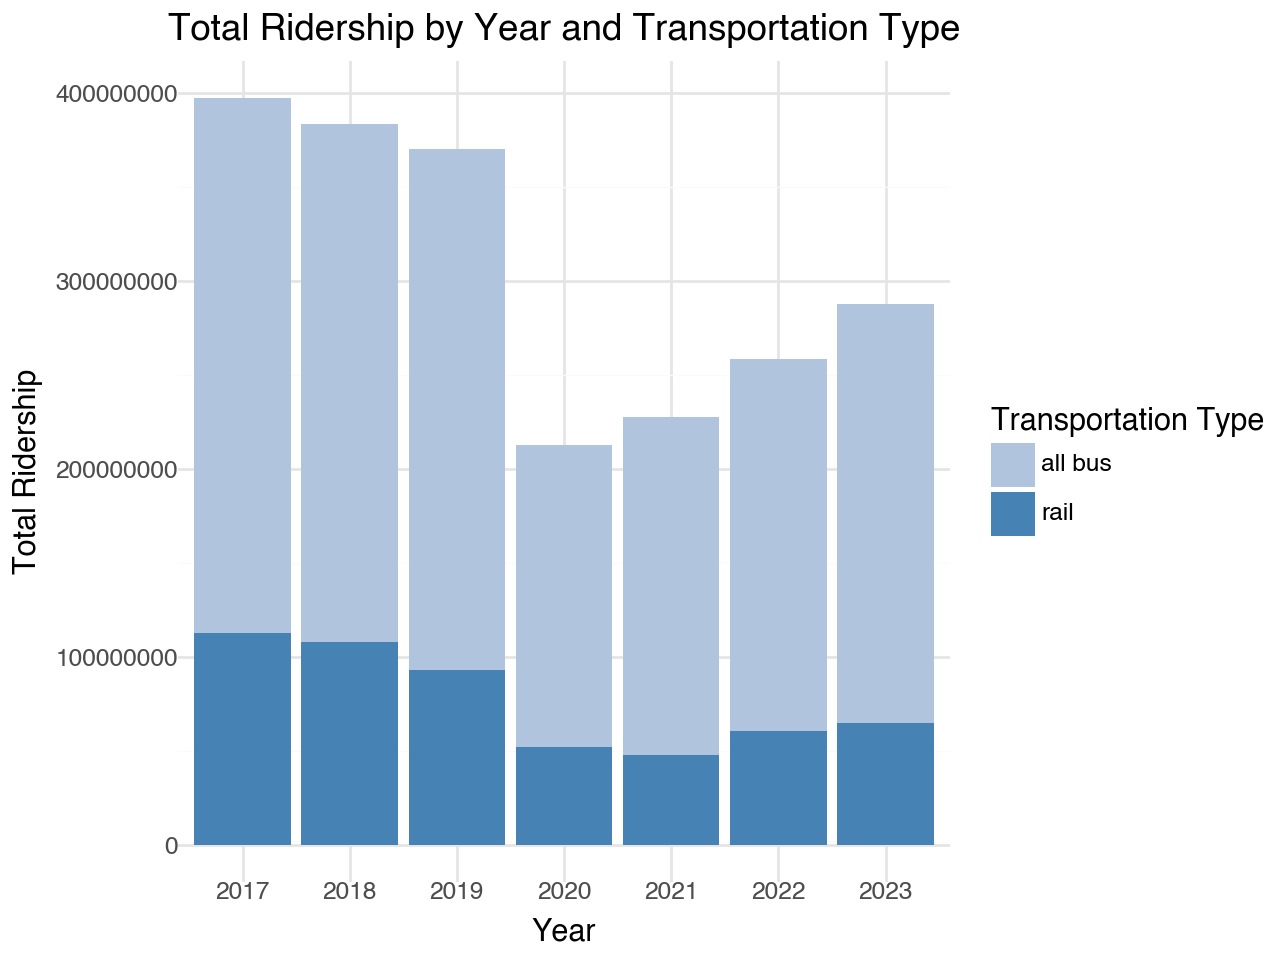

In [5]:
# Colors for transportation types
colors = {
    'all bus': 'lightsteelblue',
    'rail': 'steelblue'
}

# Creating the bubble plot with controlled regression line extension
(
    ggplot(data, aes(x='total_ridership', y='emission', size='avg_price', fill='transportation_type'))
    + geom_point(alpha=0.9, color='black', stroke=0.2)  # Bubble plot
    + geom_smooth(
        aes(group='transportation_type', color='transportation_type'),
        method='lm', se=False, fullrange=True  # Extend regression lines
    )
    + scale_fill_manual(
        name='Transportation Type',
        values=colors
    )
    + scale_color_manual(
        name='Transportation Type',
        values=colors
    )
    + labs(
        x='Total Ridership',
        y='CO2 Emissions (lbs)',
        fill='Transportation Type'
    )
    + guides(size=False)  # Hides the size legend
    + xlim(
        data['total_ridership'].min() * 0.95,  # Slightly less than the minimum observed
        data['total_ridership'].max() * 1.05   # Slightly more than the maximum observed
    )
    + theme_bw()
)


### Elastic Net Model

All Coefficients:
                                    Feature   Coefficient
0                                      year -2.134533e+06
1                           total_ridership  1.008746e+07
2                                 avg_price -1.784773e+05
3                  transportation_type_rail -3.616948e+06
4                      year total_ridership -1.978626e+06
5                            year avg_price  6.251893e+05
6             year transportation_type_rail -3.291138e+05
7                 total_ridership avg_price -9.346049e+05
8  total_ridership transportation_type_rail  3.419450e+06
9        avg_price transportation_type_rail -6.011753e+05
Interaction Coefficients:
                                    Feature   Coefficient
4                      year total_ridership -1.978626e+06
5                            year avg_price  6.251893e+05
6             year transportation_type_rail -3.291138e+05
7                 total_ridership avg_price -9.346049e+05
8  total_ridership transport

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


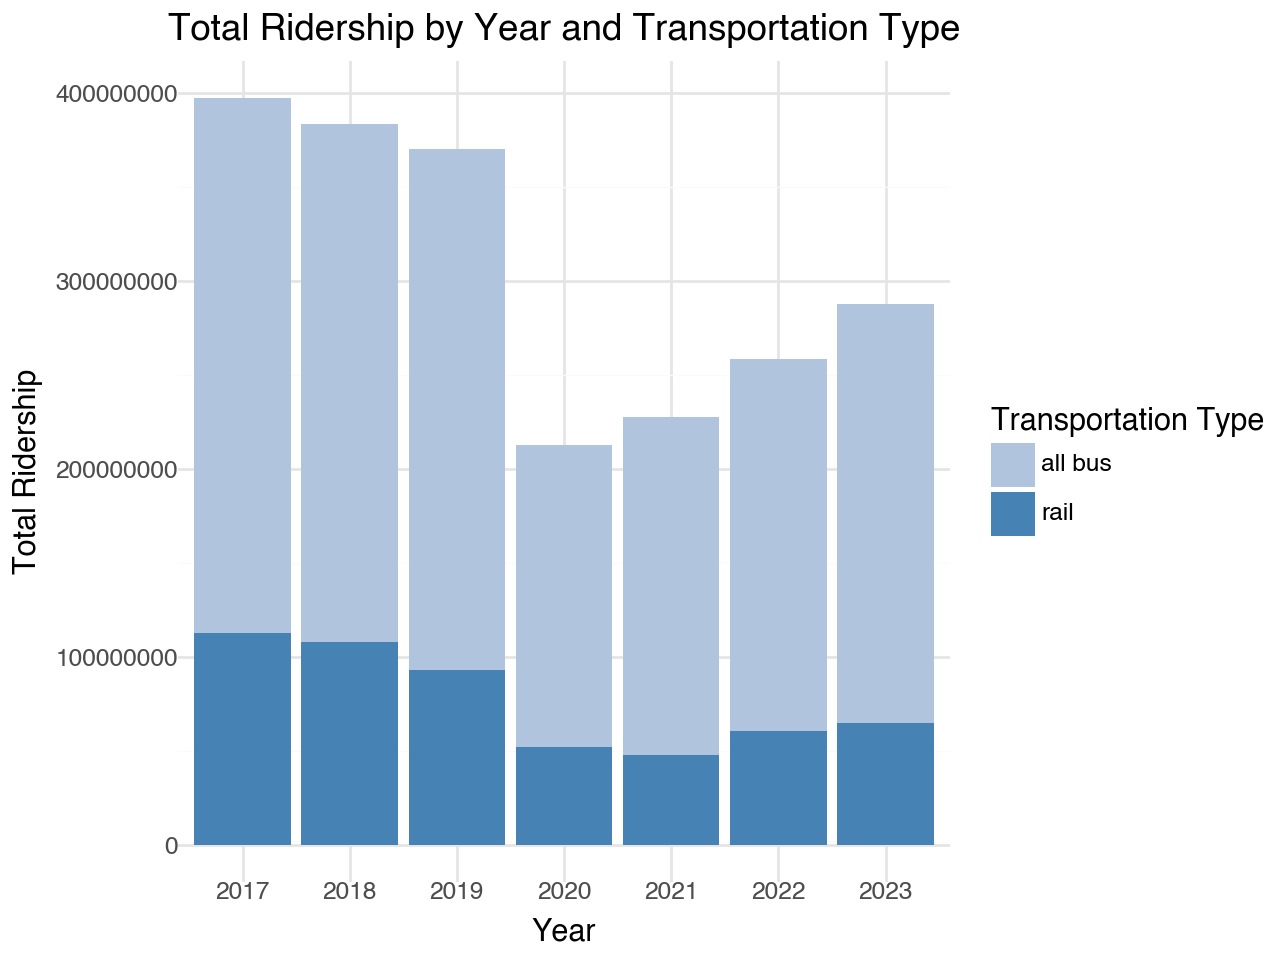

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import pandas as pd

# Split the data
X = data[['year', 'transportation_type', 'total_ridership', 'avg_price']]
y = data['emission']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['year', 'total_ridership', 'avg_price']),
        ('cat', OneHotEncoder(drop='first'), ['transportation_type'])
    ]
)

# Create pipeline to add interactions
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Add interactions
    ('elasticnet', ElasticNet(random_state=1))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get feature names after interactions
preprocessed_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(['year', 'total_ridership', 'avg_price']).tolist()
    + preprocessor.named_transformers_['cat'].get_feature_names_out(['transportation_type']).tolist()
)
poly = pipeline.named_steps['interactions']
interaction_names = poly.get_feature_names_out(preprocessed_names)

# Extract coefficients
elasticnet_model = pipeline.named_steps['elasticnet']
coefficients = pd.DataFrame({
    'Feature': interaction_names,
    'Coefficient': elasticnet_model.coef_
})

# Debugging: Print all coefficients to confirm interactions exist
print("All Coefficients:")
print(coefficients)

# Adjust filter for interaction terms
interaction_terms = coefficients[coefficients['Feature'].str.contains(' ')]

# If interaction_terms is still empty, skip filtering
if interaction_terms.empty:
    interaction_terms = coefficients

# Print interaction coefficients
print("Interaction Coefficients:")
print(interaction_terms)


#### Tuning Elastic Net

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e+14, tolerance: 4.136e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+14, tolerance: 4.024e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+14, tolerance: 4.319e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e+14, tolerance: 4.136e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+14, tolerance: 4.024e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e+14, tolerance: 4.319e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.288e+13, tolerance: 4.136e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+14, tolerance: 4.024e+12
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+14, tolerance: 4.419e+12


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e+14, tolerance: 5.257e+12
/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


Best Hyperparameters Found:
{'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
Best Model's Interaction Coefficients:
                                    Feature   Coefficient
4                      year total_ridership -2.566707e+04
5                            year avg_price  1.741738e+05
6             year transportation_type_rail  1.592817e+06
7                 total_ridership avg_price  1.192022e+06
8  total_ridership transportation_type_rail -5.678717e+06
9        avg_price transportation_type_rail  2.271150e+06
Best Hyperparameters Found:
{'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
Best Model's Interaction Coefficients:
                                    Feature   Coefficient
4                      year total_ridership -2.566707e+04
5                            year avg_price  1.741738e+05
6             year transportation_type_rail  1.592817e+06
7                 total_ridership avg_price  1.192022e+06
8  total_ridership transportation_type_rail -5.678717e

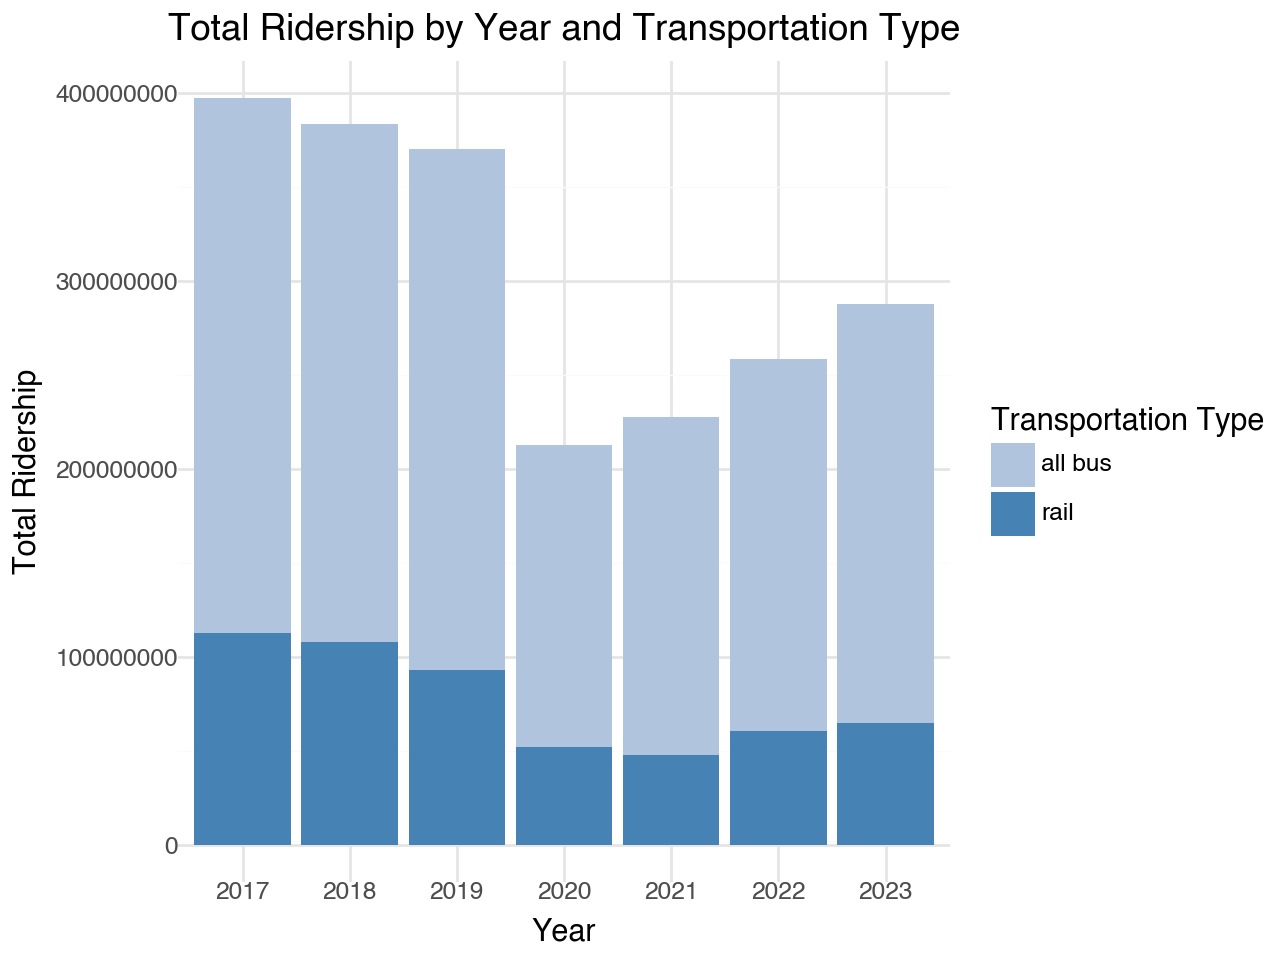

In [7]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Hyperparameters Found:")
print(grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

# Get coefficients from the best model
elasticnet_model_best = best_model.named_steps['elasticnet']
interaction_names_best = best_model.named_steps['interactions'].get_feature_names_out(preprocessed_names)
coefficients_best = pd.DataFrame({
    'Feature': interaction_names_best,
    'Coefficient': elasticnet_model_best.coef_
})

# Filter for significant interaction terms
interaction_terms_best = coefficients_best[coefficients_best['Feature'].str.contains(' ')]

print("Best Model's Interaction Coefficients:")
print(interaction_terms_best)


### Interaction Heatmap

<positron-console-cell-8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-8>:12: FutureWarning: The provided callable <function mean at 0x104aa1c60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


Interaction Coefficient Matrix:
Feature2            avg_price  ...  transportation_type_rail
Feature1                       ...                          
avg_price        0.000000e+00  ...              2.271150e+06
total_ridership  1.192022e+06  ...             -5.678717e+06
year             1.741738e+05  ...              1.592817e+06

[3 rows x 3 columns]
Interaction Coefficient Matrix:
Feature2            avg_price  ...  transportation_type_rail
Feature1                       ...                          
avg_price        0.000000e+00  ...              2.271150e+06
total_ridership  1.192022e+06  ...             -5.678717e+06
year             1.741738e+05  ...              1.592817e+06

[3 rows x 3 columns]


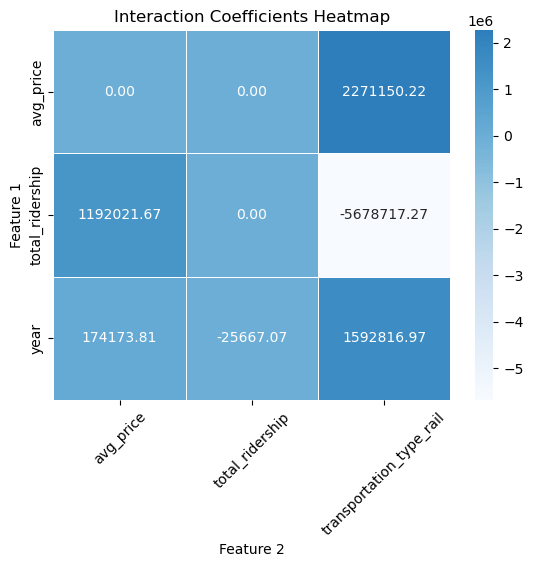

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


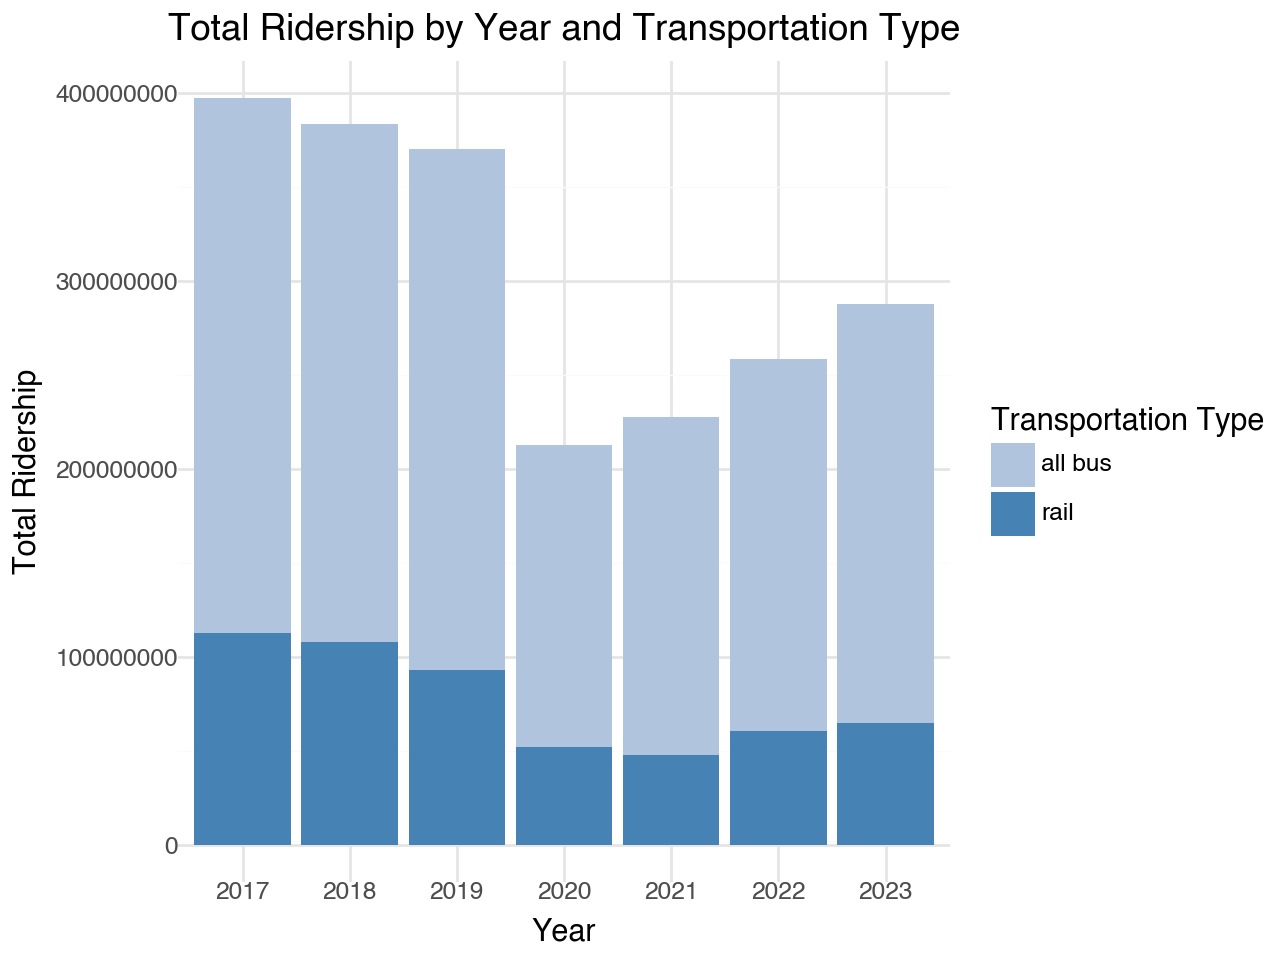

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract interaction terms (those with spaces in their names)
interaction_terms_best = coefficients_best[coefficients_best['Feature'].str.contains(' ')]

# Split the interaction feature names into pairs of features
interaction_terms_best[['Feature1', 'Feature2']] = interaction_terms_best['Feature'].str.split(' ', expand=True)

# Pivot the interaction terms into a matrix format
interaction_matrix = interaction_terms_best.pivot_table(
    index='Feature1', 
    columns='Feature2', 
    values='Coefficient', 
    aggfunc=np.mean,  # In case of duplicates, average coefficients
    fill_value=0      # Fill missing values with 0
)

# Print the interaction matrix for debugging
print("Interaction Coefficient Matrix:")
print(interaction_matrix)

# Apply the 'Blues' colormap for dark-to-light blue gradient
sns.heatmap(interaction_matrix, annot=True, cmap='Blues', center=0, fmt='.2f', linewidths=0.5)

# Customize the heatmap appearance
plt.title('Interaction Coefficients Heatmap')
plt.xlabel('Feature 2')
plt.ylabel('Feature 1')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()
